In [1]:
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import utils.visualisations
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets

import utils.metrics
import utils.model

import models.lenet
from datasets.transforms import AddGaussianNoise

In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


Load the dataset

In [ ]:
transforms = torchvision.transforms.Compose([torchvision.transforms.Resize((32, 32)),
                                             torchvision.transforms.ToTensor()])


data_train = torchvision.datasets.FashionMNIST(
    "fmnist", download=True, train=True, transform=transforms)

train_set_size = int(len(data_train) * 0.9)
valid_set_size = len(data_train) - train_set_size
data_train, data_val = torch.utils.data.random_split(
    data_train, [train_set_size, valid_set_size], generator=torch.Generator().manual_seed(0))

data_loader_train = torch.utils.data.DataLoader(data_train,
                                                batch_size=32,
                                                shuffle=True,
                                                )

                                                

transforms_test = torchvision.transforms.Compose([torchvision.transforms.Resize((32, 32)),
                                             torchvision.transforms.ToTensor(),
                                             ])

data_loader_val = torch.utils.data.DataLoader(data_val,
                                               batch_size=32,
                                               shuffle=False)

data_test = torchvision.datasets.FashionMNIST(
    "fmnist", download=True, train=False, transform=transforms_test)
data_loader_test = torch.utils.data.DataLoader(data_test,
                                               batch_size=32,
                                               shuffle=False)

dataset_sizes = {"train": len(data_train), "val": len(data_test)}
data_loaders = {"train": data_loader_train, "val": data_loader_test}

Draw an example of dataset

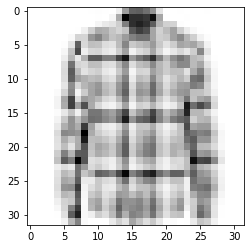

In [6]:
plt.imshow(data_test[7][0].permute((1,2,0)), cmap="Greys")

Load the models

In [25]:
# weights of the standard model but with dropout p=0.15. 
# Dropout is turned of for evaluation of the standard model.
model_dropout = torch.load("checkpoints/lenet-fmnist-dropout0.2.pt", map_location=device)
weights = torch.load("checkpoints/lenet-fmnist.pt", map_location=device)
model_dropout.load_state_dict(weights.state_dict())
model = model_dropout
model.feature_extractor[9] = torch.nn.Dropout2d(p=0.15)
utils.mc_dropout.set_dropout_p(model, model, .15)

# Dropout model
model_dropout = torch.load("checkpoints/lenet-fmnist-dropout0.2.pt", map_location=device)

# Ensemble
import utils.torchensemble
from torchensemble.utils import io
from torchensemble import VotingClassifier

model_ensemble = VotingClassifier(models.lenet.LeNet5(), 5, cuda=device.type=="cuda")
utils.torchensemble.load(model_ensemble, device, "checkpoints")

# Temperature scaling
from utils.temperature_scaling import ModelWithTemperature
scaled_model = ModelWithTemperature(model, device)
scaled_model.set_temperature(data_loader_val)

Before temperature - NLL: 0.469, ECE: 0.059
Optimal temperature: 1.463
After temperature - NLL: 0.432, ECE: 0.012


ModelWithTemperature(
  (model): LeNet5_dropout(
    (feature_extractor): Sequential(
      (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
      (1): Tanh()
      (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
      (4): Tanh()
      (5): Dropout2d(p=0.15, inplace=False)
      (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (7): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
      (8): Tanh()
      (9): Dropout2d(p=0.15, inplace=False)
    )
    (classifier): Sequential(
      (0): Linear(in_features=120, out_features=84, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.15, inplace=False)
      (3): Linear(in_features=84, out_features=10, bias=True)
    )
  )
)

Validate the models.

In [12]:
progress_model= utils.model.run_validation(
    model, data_loaders["val"], utils.metrics.Progress(), device, mc_dropout_iters=20)

progress_model_dropout = utils.model.run_validation(
    model_dropout, data_loaders["val"], utils.metrics.Progress(), device, mc_dropout_iters=20)

progress_model_scaled = utils.model.run_validation(
    scaled_model, data_loaders["val"], utils.metrics.Progress(), device, mc_dropout_iters=0)

progress_model_ensemble = utils.model.run_validation(
    model_ensemble, data_loaders["val"], utils.metrics.Progress(), device, mc_dropout_iters=0)

Avg. acc.: 90.20: 100%|██████████| 313/313 [00:02<00:00, 108.94it/s]


Draw examples of bad classifications with high confidence

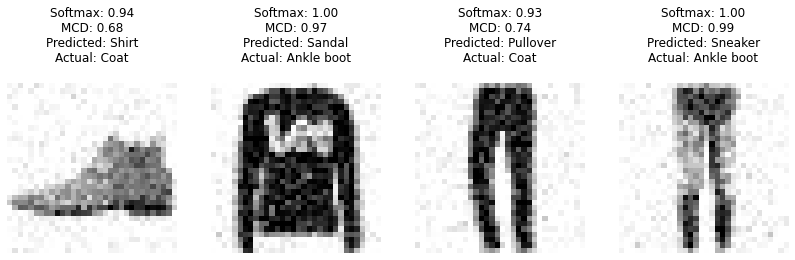

In [25]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]


incorrect = np.argwhere((progress_model.predictions != progress_model.labels) & (progress_model.max_probs > .9)).ravel()
idx = np.argsort(progress_model.max_probs)[::-1][incorrect]
idx=incorrect
num = 4
fig, axs = plt.subplots(1, num, figsize=(14,7))
dropout_max_probs_untrained = progress_model.dropout_outputs.max(axis=-1)

for i in range(num):
    axs[i].imshow(data_test[i][0].permute(1,2,0), cmap="Greys")
    axs[i].set_title(
        f"Softmax: {progress_model.max_probs[idx[i]]:.2f}\n"
        f"MCD: {dropout_max_probs_untrained[idx[i]]:.2f}\n"
        f"Predicted: {class_names[int(progress_model.predictions[idx[i]])]}\n"
        f"Actual: {class_names[int(progress_model.labels[idx[i]])]}\n"
    )
    axs[i].axis("off")


Validate the models.

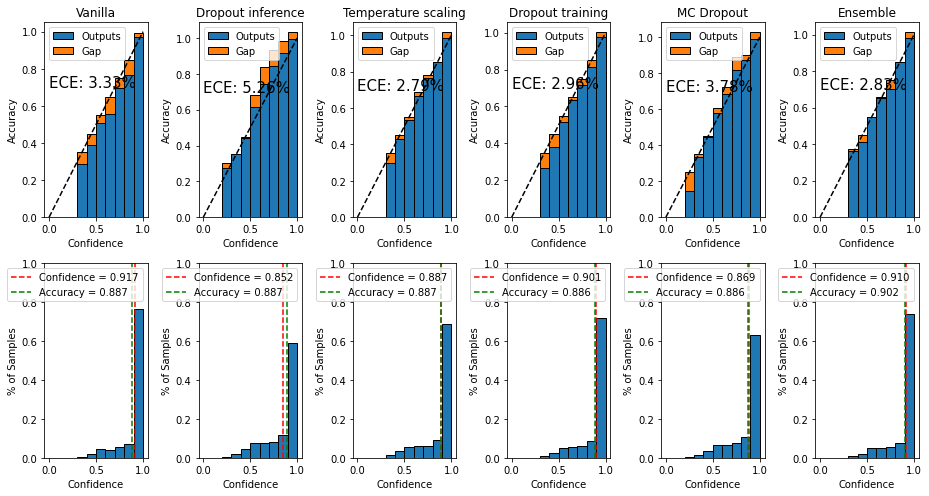

In [43]:
ensemble_max_probs = progress_model_ensemble.logits.max(axis=1)

utils.visualisations.calibration_graph([
        ("Vanilla", progress_model.max_probs, np.argsort(progress_model.max_probs), progress_model.predictions),
        ("Dropout inference", progress_model.dropout_max_probs, np.argsort(progress_model.dropout_max_probs), progress_model.dropout_predictions),
        ("Temperature scaling", progress_model_scaled.max_probs, np.argsort(progress_model_scaled.max_probs), progress_model_scaled.predictions),
        ("Dropout training", progress_model_dropout.max_probs, np.argsort(progress_model_dropout.max_probs), progress_model_dropout.predictions),
        ("MC Dropout", progress_model_dropout.dropout_max_probs, np.argsort(progress_model_dropout.dropout_max_probs), progress_model_dropout.dropout_predictions),
        ("Ensemble", ensemble_max_probs, np.argsort(ensemble_max_probs), progress_model_ensemble.predictions),
    
    ],
    progress_model_dropout.labels, figsize=(13,7)
    )

# plt.savefig("figures/fmnist-calibration1.pdf")

Compute the ROC and PR curves and print the ROC curve 

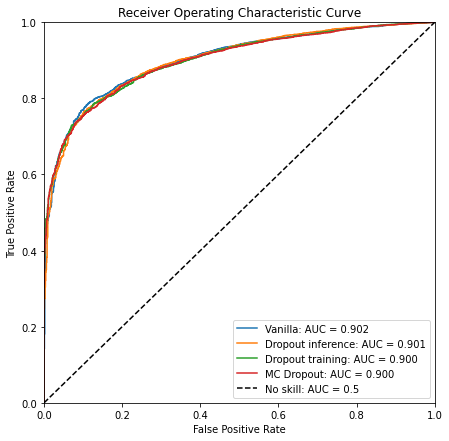

In [24]:
curves = []

correct = progress_model.predictions == progress_model.labels
max_probs = progress_model.max_probs
curves.append(utils.metrics.compute_model_stats(correct, max_probs, "Vanilla"))

correct = progress_model.dropout_predictions == progress_model.labels
max_probs = progress_model.dropout_outputs.max(axis=-1)
curves.append(utils.metrics.compute_model_stats(correct, max_probs, "Dropout inference"))



correct = progress_model_dropout.predictions == progress_model.labels
max_probs = progress_model_dropout.max_probs
curves.append(utils.metrics.compute_model_stats(correct, max_probs, "Dropout training"))

correct = progress_model_dropout.dropout_predictions == progress_model.labels
max_probs = progress_model_dropout.dropout_outputs.max(axis=-1)
curves.append(utils.metrics.compute_model_stats(correct, max_probs, "MC Dropout"))




plt.figure(figsize=(7,7))
plt.title('Receiver Operating Characteristic Curve')
for curve in curves:
    plt.plot(curve["fpr"], curve["tpr"], label = f"{curve['label']}: AUC = {curve['auroc']:.3f}" )
plt.plot([0, 1], [0, 1],'k--', label=f"No skill: AUC = 0.5")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend()

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
# plt.savefig("figures/roc-example.pdf")

Print the PR curve

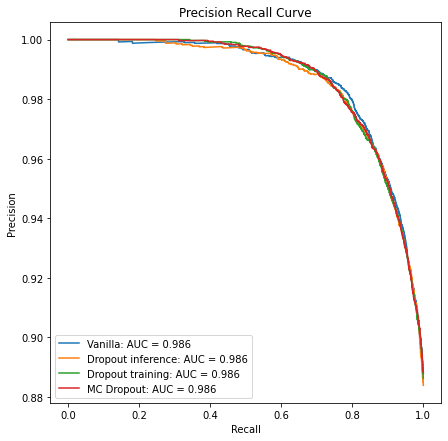

In [27]:
plt.figure(figsize=(7,7))
plt.title('Precision Recall Curve')
for curve in curves:
    plt.plot(curve["recall"], curve["prec"], label=f"{curve['label']}: AUC = {curve['aupr']:.3f}")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# plt.savefig("figures/PR-example.pdf")

Validate the models on the shifted dataset

In [46]:
curves = {
    "Vanilla": utils.metrics.model_metrics(),
    "Dropout inference": utils.metrics.model_metrics(),
    "Temperature scaling":utils.metrics.model_metrics(),

    "Dropout training": utils.metrics.model_metrics(),
    "Monte Carlo Dropout":utils.metrics.model_metrics(),
    "Ensemble":utils.metrics.model_metrics(),

}




for s in np.arange(0, 0.6, 0.05):
    transforms= torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize((32, 32)),
            # torchvision.transforms.RandomRotation(degrees=(s,s)),
            torchvision.transforms.ToTensor(),
            AddGaussianNoise(std=s)
        ])

    data_test = torchvision.datasets.FashionMNIST(
        "fmnist", download=True, train=False, transform=transforms)
    data_loader_test = torch.utils.data.DataLoader(data_test,
                                                batch_size=32,
                                                shuffle=False)
    

    print(f"Strength: {s}")
    progress_model= utils.model.run_validation(
        model, data_loader_test, utils.metrics.Progress(), device, mc_dropout_iters=20)

    progress_model_dropout = utils.model.run_validation(
        model_dropout, data_loader_test, utils.metrics.Progress(), device, mc_dropout_iters=20)

    progress_model_scaled = utils.model.run_validation(
        scaled_model, data_loader_test, utils.metrics.Progress(), device, mc_dropout_iters=0)

    progress_model_ensemble = utils.model.run_validation(
        model_ensemble, data_loader_test, utils.metrics.Progress(), device, mc_dropout_iters=0)


    bins = np.linspace(0.05, 0.95, num=10)
    labels = progress_model.labels

    max_probs = progress_model.dropout_outputs.max(axis=-1)
    utils.metrics.update_model_metrics(progress_model, progress_model.dropout_outputs, max_probs, progress_model.dropout_predictions, labels, bins, curves["Dropout inference"], s)
    
    max_probs = progress_model.max_probs
    utils.metrics.update_model_metrics(progress_model, progress_model.probs, max_probs, progress_model.predictions, labels, bins, curves["Vanilla"], s)

    max_probs = progress_model_dropout.max_probs
    utils.metrics.update_model_metrics(progress_model_dropout, progress_model_dropout.probs, max_probs, progress_model_dropout.predictions, labels, bins, curves["Dropout training"], s)

    max_probs = progress_model_dropout.dropout_outputs.max(axis=-1)
    utils.metrics.update_model_metrics(progress_model_dropout, progress_model_dropout.dropout_outputs, max_probs, progress_model_dropout.dropout_predictions, labels, bins, curves["Monte Carlo Dropout"], s)

    max_probs = progress_model_scaled.max_probs
    utils.metrics.update_model_metrics(progress_model_scaled, progress_model_scaled.probs, max_probs, progress_model_scaled.predictions, labels, bins, curves["Temperature scaling"], s)

    max_probs = progress_model_ensemble.logits.max(axis=-1)
    utils.metrics.update_model_metrics(progress_model_ensemble, progress_model_ensemble.logits, max_probs, progress_model_ensemble.predictions, labels, bins, curves["Ensemble"], s)

Strength: 0.0


Avg. acc.: 90.20: 100%|██████████| 313/313 [00:03<00:00, 90.43it/s]


Strength: 0.05


Avg. acc.: 89.83: 100%|██████████| 313/313 [00:03<00:00, 90.24it/s]


Strength: 0.1


Avg. acc.: 88.86: 100%|██████████| 313/313 [00:03<00:00, 103.19it/s]


Strength: 0.15000000000000002


Avg. acc.: 87.16: 100%|██████████| 313/313 [00:03<00:00, 98.08it/s] 


Strength: 0.2


Avg. acc.: 85.52: 100%|██████████| 313/313 [00:03<00:00, 94.72it/s] 


Strength: 0.25


Avg. acc.: 81.49: 100%|██████████| 313/313 [00:03<00:00, 87.73it/s]


Strength: 0.30000000000000004


Avg. acc.: 77.02: 100%|██████████| 313/313 [00:03<00:00, 85.78it/s]


Strength: 0.35000000000000003


Avg. acc.: 72.05: 100%|██████████| 313/313 [00:02<00:00, 107.16it/s]


Strength: 0.4


Avg. acc.: 66.96: 100%|██████████| 313/313 [00:03<00:00, 89.15it/s]


Strength: 0.45


Avg. acc.: 62.81: 100%|██████████| 313/313 [00:03<00:00, 83.37it/s]


Strength: 0.5


Avg. acc.: 57.83: 100%|██████████| 313/313 [00:03<00:00, 87.25it/s]


Strength: 0.55


Avg. acc.: 54.37: 100%|██████████| 313/313 [00:02<00:00, 107.47it/s]


Save the results of evaluation on shifted datasets

In [37]:
import pickle
with open("experiments/noise_fmnist.pickle", "wb") as f:
    pickle.dump(curves,f)

or Load previous results

In [1]:
import pickle
with open("experiments/noise_fmnist.pickle", "rb") as f:
    curves = pickle.load(f)

Print latex table of results on the standard dataset

In [23]:
import pandas as pd
df = pd.DataFrame()

for label, prog in curves.items():
    row = {"label":label}

    for name,val in vars(prog).items():
        if len(val)>0:
            row[name] = val[0]
    df=df.append(row,ignore_index=True)
print(df.to_latex(columns=["label", "acc", "ece", "confs", "brier", "auroc", "aupr"], float_format="%.3f"))

\begin{tabular}{llrrrrrr}
\toprule
{} &             label &   acc &   ece &  confs &  brier &  auroc &  aupr \\
\midrule
0 &               mcd & 0.888 & 5.241 &  0.852 &  0.016 &  0.899 & 0.986 \\
1 &          baseline & 0.887 & 3.330 &  0.917 &  0.016 &  0.902 & 0.986 \\
2 &  baseline\_dropout & 0.886 & 2.956 &  0.901 &  0.016 &  0.900 & 0.986 \\
3 &       mcd\_trained & 0.884 & 3.875 &  0.869 &  0.016 &  0.901 & 0.986 \\
4 &      temp\_scaling & 0.887 & 3.444 &  0.874 &  0.016 &  0.903 & 0.987 \\
5 &          ensemble & 0.902 & 2.834 &  0.910 &  0.014 &  0.908 & 0.989 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_2110686/3387859279.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(row,ignore_index=True)
/tmp/ipykernel_2110686/3387859279.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(row,ignore_index=True)
/tmp/ipykernel_2110686/3387859279.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(row,ignore_index=True)
/tmp/ipykernel_2110686/3387859279.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(row,ignore_index=True)
/tmp/ipykernel_2110686/3387859279.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use p

Draw a figure of metrics changing with strength of shift

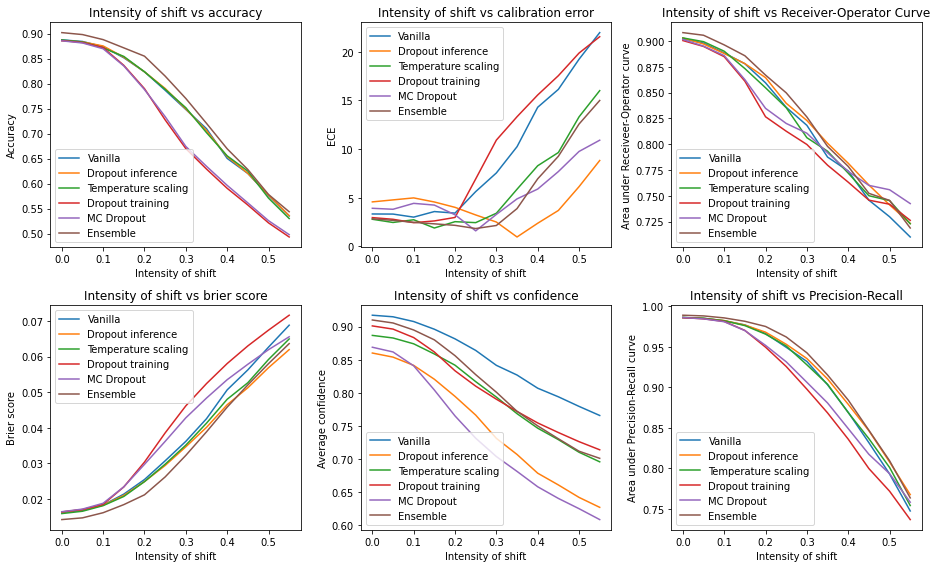

In [49]:
fig, axs = plt.subplots(2, 3, figsize=(13, 8))
for name, m in curves.items():
    ax = axs[0][0]
    ax.plot(m.strengths, m.acc, label=name)
    ax.legend()
    ax.set_title("Intensity of shift vs accuracy")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("Accuracy")

    ax = axs[1][0]
    ax.plot(m.strengths, m.brier, label=name)
    ax.legend()
    ax.set_title("Intensity of shift vs brier score")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("Brier score")

    ax = axs[0][1]
    ax.plot(m.strengths, m.ece, label=name)
    ax.legend()
    ax.set_title("Intensity of shift vs calibration error")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("ECE")

    ax = axs[1][1]
    ax.plot(m.strengths, m.confs, label=name)
    ax.legend()
    ax.set_title("Intensity of shift vs confidence")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("Average confidence")

    ax = axs[0][2]
    ax.plot(m.strengths, m.auroc, label=name)
    ax.legend()
    ax.set_title("Intensity of shift vs Receiver-Operator Curve")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("Area under Receiveer-Operator curve")

    ax = axs[1][2]
    ax.plot(m.strengths, m.aupr, label=name)
    ax.legend()
    ax.set_title("Intensity of shift vs Precision-Recall")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("Area under Precision-Recall curve")
fig.tight_layout()

plt.savefig("figures/fmnist-noise.pdf")